### Optical Beat Note between multiple wave

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.constants import c

In [26]:
def propagate(phase1, phase2, Ein=np.array([[1],[0]])):

    propagatematrix1 = np.array([[np.exp(1j*phase1),0],[0,np.exp(1j*phase2)]]);

    Eout = np.dot(propagatematrix1,Ein)
    
    return Eout


def beamsplitter(PT,Ein):

   # See Wikipedia for details. https://en.wikipedia.org/wiki/Beam_splitter       

   # Dielectric type Beam Splitter
     #phiT = 0
     #phiR = 0
     #phiO = 0

   # Symmetric type Beam Splitter
     phiT = 0
     phiR = -0.5 * np.pi    
     phiO = 0.5 * np.pi
     
     T = np.sqrt(PT) # Transmission defined as Electric field

     PR = 1-PT 

     R = np.sqrt(PR) # Reflection defined as Electric field

     Theta1 = np.arctan(R/T) # Split Raio in Radian   
         
     BSmatrix1 = np.dot(np.exp(1J*phiO),np.array([[np.sin(Theta1)*np.exp(1J*phiR),np.cos(Theta1)*np.exp(-1J*phiT)],[np.cos(Theta1)*np.exp(1j*phiT),-1*np.sin(Theta1)*np.exp(-1J*phiR)]]))
     
     Eout = np.dot(BSmatrix1, Ein)

     return Eout


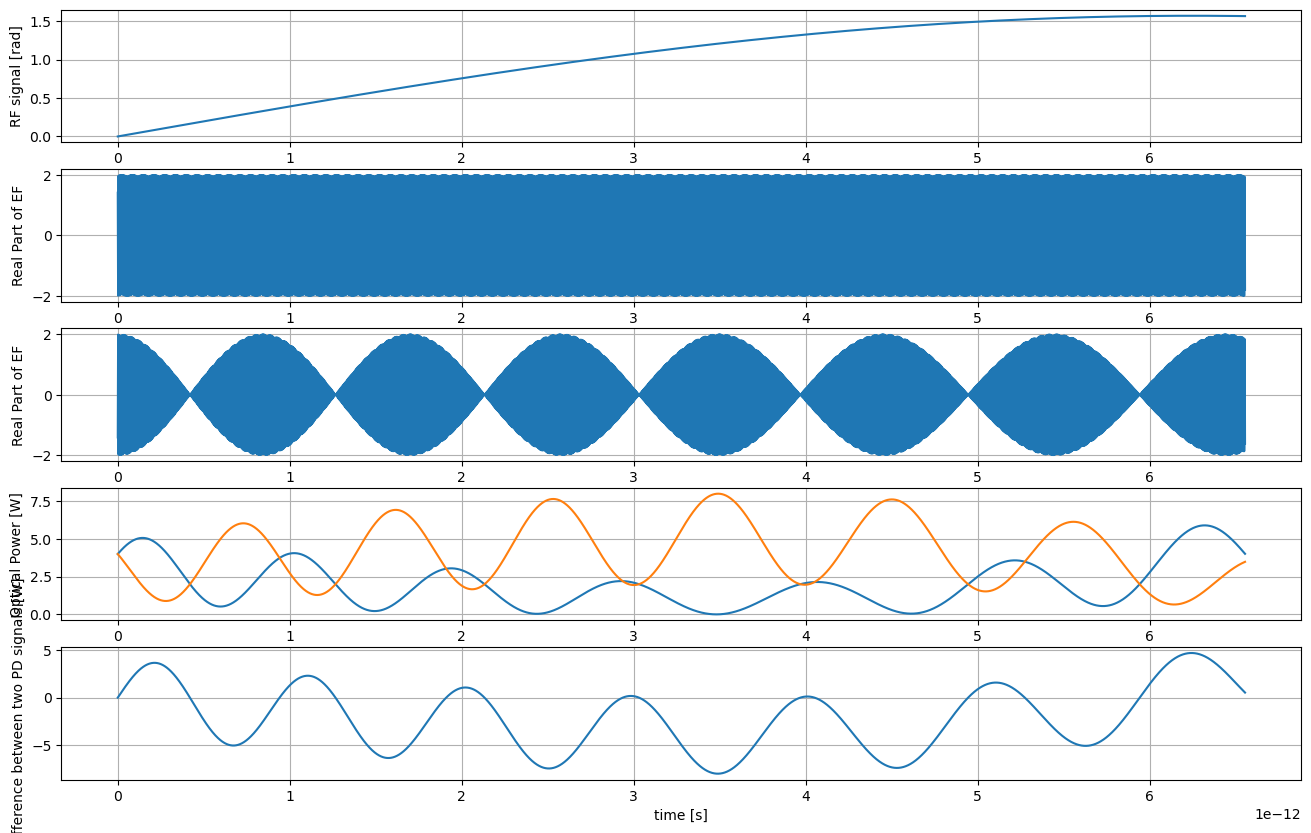

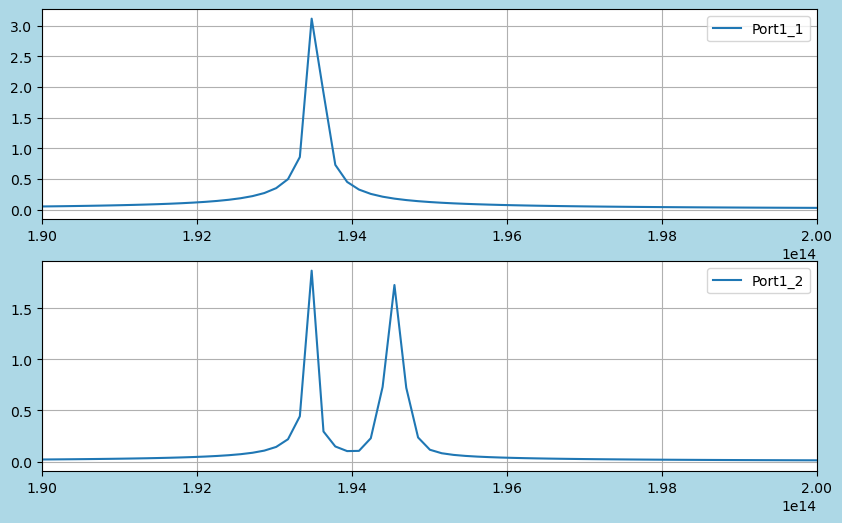

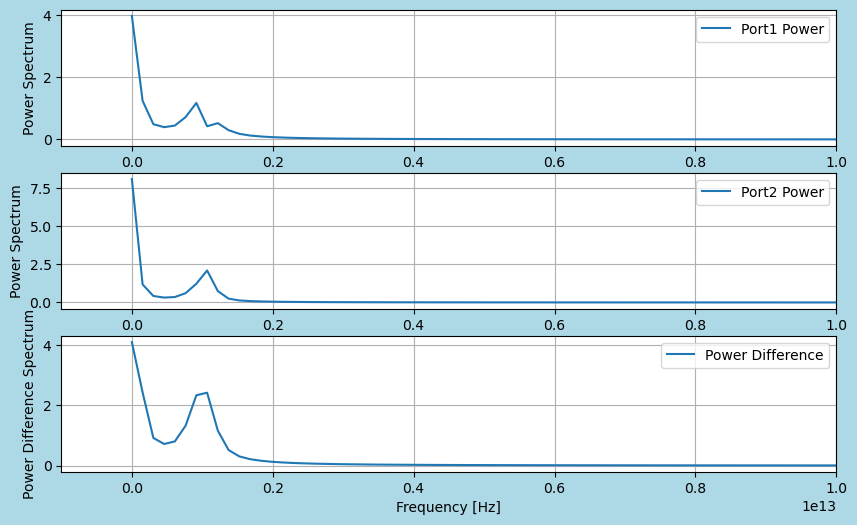

In [27]:
samplerate = 2**14 # Number of Points
t_step = 4 * 1e-16 #[s]

tcol = np.linspace(0.0, t_step * samplerate, samplerate, endpoint=False)

amp_c = 0.5 * np.pi
#amp_c = 0
freq_rf = 40e9 # [Hz]

freq_rf_2 = 80e9 # [Hz]


md = 1 # modulation depth. 1 = 100 %
dc_offset = 0 # DC offset

no = 1 # Refractive Index of medium

oplcommon1=100 #Common Path Length 1
oplcommon2=100 #Common Path Length 2

opl1 =100 
opl2= 100

wl1 = 1549e-9
wl2 = 1550e-9
wl3 = 1541e-9

# If wl1 and wl2 are equal, homodyne. If not, heterodyne.

lightfreq1 = c / wl1 # Local Oscillator
lightfreq2 = c / wl2
lightfreq3 = c / wl3


PT1 = 0.5 # PT: Power Transmission of Beam splitter

# Define Input Electric Field: Both 1 and 2 port

#Ein1 = np.array([[1+0j],[1-0j]]) 
Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
#Ein1 = np.array([[1 + 0j],[-1 - 0j]])

#tcol = np.zeros(samplerate)
rfsignalcol = np.zeros(samplerate)
Port1_1_EFcol = np.zeros(samplerate, dtype=complex)
Port1_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_EFcol = np.zeros(samplerate,dtype=complex)
Port3_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_powercol = np.zeros(samplerate)
Port3_2_powercol = np.zeros(samplerate)
Power_diffcol = np.zeros(samplerate)

for ii in range(samplerate):
    
    t = tcol[ii]

    rf_signal = amp_c * np.sin(2 * np.pi * freq_rf * t) + dc_offset #[rad]
    rfsignalcol[ii] = rf_signal

    rf_signal_2 = amp_c * np.sin(2 * np.pi * freq_rf_2 * t) + dc_offset #[rad]
    
    # Path Length modulated

    phase1 = 2*np.pi * lightfreq1 * t # phase of local oscillator [rad]

    phase2 = 2*np.pi * lightfreq2 * t + rf_signal #[rad]
    phase3 = 2*np.pi * lightfreq3 * t + rf_signal_2 #[rad]

    Eout1_a = propagate(phase1, phase2, Ein1)
    Eout1_b = propagate(phase1, phase3, Ein1)

    #Eout1 = Eout1_a
    #Eout1 = Eout1_b
    Eout1 = Eout1_a +  Eout1_b

    Port1_1_Eout = Eout1[0,0] # Modulated Light signal
    Port1_1_EFcol[ii] = Port1_1_Eout
    
    Port1_2_Eout = Eout1[1,0] # Local Oscillator
    Port1_2_EFcol[ii] = Port1_2_Eout

    Ein2 = Eout1

    Eout2 = beamsplitter(PT1, Ein2)
    Ein3 = Eout2    
   
    Eout3 = propagate(0, 0, Ein3)
    
    #Trans
    Port3_1_Eout = Eout3[0,0]
    Port3_1_EFcol[ii] = Port3_1_Eout

    power3_1 = (np.abs(Port3_1_Eout))**2 # Optical power is calculated as squared of absolute electric field strength
    Port3_1_powercol[ii] = power3_1

    #Reflect
    Port3_2_Eout = Eout3[1,0] 
    Port3_2_EFcol[ii] = Port3_2_Eout

    power3_2 = (np.abs(Port3_2_Eout))**2
    Port3_2_powercol[ii] = power3_2
    
    # Power Difference
    Power_diff = power3_1 - power3_2
    Power_diffcol[ii] = Power_diff
 

fig1, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, figsize = (16,10), sharey=False)

ax1.plot(tcol,rfsignalcol)
ax1.set_ylabel("RF signal [rad]")
#ax1.set_ylim(-3.14,3.14)
ax1.grid()

ax2.plot(tcol,np.real(Port1_1_EFcol))
ax2.set_ylabel("Real Part of EF")
#ax2.set_ylim(-3, 3)
ax2.grid()

ax3.plot(tcol,np.real(Port1_2_EFcol))
ax3.set_ylabel("Real Part of EF")
#ax2.set_ylim(-3, 3)
ax3.grid()

ax4.plot(tcol,Port3_1_powercol,tcol,Port3_2_powercol)
ax4.set_ylabel("Optical Power [W]")
#ax4.set_ylim(-0.2,2.2)
ax4.grid(True)

ax5.plot(tcol,Power_diffcol)
ax5.set_xlabel("time [s]")
ax5.set_ylabel("Difference between two PD signals [W]")
ax5.grid()

fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax2_1 = fig2.add_subplot(2, 1, 1)
ax2_2 = fig2.add_subplot(2, 1, 2)

xf = fftfreq(samplerate, t_step)[:samplerate//2]

Port1_1_EFcol_f = fft(Port1_1_EFcol)
Port1_2_EFcol_f = fft(Port1_2_EFcol)

ax2_1.plot(xf, 2.0/samplerate * np.abs(Port1_1_EFcol_f[0:samplerate//2]),label="Port1_1")
ax2_1.set_xlim(190e12,200e12)
ax2_1.legend()
ax2_1.grid(True)

ax2_2.plot(xf, 2.0/samplerate * np.abs(Port1_2_EFcol_f[0:samplerate//2]),label="Port1_2")
ax2_2.set_xlim(190e12,200e12)
ax2_2.legend()
ax2_2.grid(True)

fig3 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax3_1 = fig3.add_subplot(3, 1, 1)
ax3_2 = fig3.add_subplot(3, 1, 2)
ax3_3 = fig3.add_subplot(3, 1, 3)

Port1_powercol_f = fft(Port3_1_powercol)
Port2_powercol_f = fft(Port3_2_powercol)

ax3_1.plot(xf, 2.0/samplerate * np.abs(Port1_powercol_f[0:samplerate//2]),label="Port1 Power")
ax3_1.set_ylabel("Power Spectrum")
ax3_1.set_xlim(-1e12,10e12)
ax3_1.legend()
ax3_1.grid(True)

ax3_2.plot(xf, 2.0/samplerate * np.abs(Port2_powercol_f[0:samplerate//2]), label="Port2 Power")
ax3_2.set_ylabel("Power Spectrum")
ax3_2.set_xlim(-1e12,10e12)
ax3_2.legend()
ax3_2.grid(True)

Power_diffcol_f = fft(Power_diffcol)
ax3_3.plot(xf, 2.0/samplerate * np.abs(Power_diffcol_f[0:samplerate//2]), label="Power Difference")
ax3_3.set_xlabel("Frequency [Hz]")
ax3_3.set_ylabel("Power Difference Spectrum")
ax3_3.set_xlim(-1e12,10e12)
ax3_3.legend()
ax3_3.grid(True)

plt.show()